In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, cluster
from kmodes.kmodes import KModes
from sklearn.model_selection import train_test_split
import prince

#Carga de la útlima versión de la data
df_clientes = pd.read_csv('pagadores_V4.csv')

df_clientes = df_clientes[df_clientes.flag == 'no']

#Se eliminan los NaN para evitar errores al correr algoritmos de la librería sklearn
df_clientes.dropna(inplace=True)

#Se estandariza la edad para hacerla más apropiada para los algoritmos de ML

df_clientes['edad_v2'] = preprocessing.StandardScaler().fit_transform(df_clientes[['edad_v1']])

El tamaño de los datos y la presencia de tanto variables numéricas como categóricas, hacen difícil la aplicación de algoritmos que de manera adecuada logren reducir la dimensionalidad de los datos. Por esta razón, se decide tomar y sobre ella entrenar un algoritmo de reducción de dimensionalidad. Por cuestiones de robuztes, se deciden agregar 57 registros que aseguran que para cada variabel aleatoria siempre haya al menos un registro con determinada categoría.

In [2]:
#Variables categóricas a incluir en la transformación
categorical_features = ['seg_str', 'ocupacion', 'tipo_vivienda','nivel_academico','estado_civil','genero','ingreso_rango']

sample_df = pd.DataFrame(columns=df_clientes.columns)
for cat_feature in categorical_features:
    for category in df_clientes[cat_feature].unique():
        #print(df_clientes[df_clientes[cat_feature]==category].sample(1))
        sample_df=pd.concat([sample_df,df_clientes[df_clientes[cat_feature]==category].sample(1,random_state=11)])

        
#8% de la data se puede transformar en un pc con cerca de 3 GB de RAM completamente disponible
small_df_clientes = train_test_split(df_clientes, test_size=0.08,random_state=11)[1]

#unimos estos datos con los 57 extraídos más arriba, para que de esta manera el transformador conozca todas las categorías
#que debe tansformar.
small_df_clientes = pd.concat([small_df_clientes,sample_df])
small_df_clientes = small_df_clientes.groupby(small_df_clientes.index).first()


del sample_df

In [ ]:
##Dataframe con features que se transforman con famd
training_famd_df = pd.DataFrame()
categorical_features = ['seg_str', 'ocupacion', 'tipo_vivienda','nivel_academico','estado_civil','genero','ingreso_rango']

for cat_feature in categorical_features:
    training_famd_df[cat_feature] = small_df_clientes[cat_feature]
    
training_famd_df['edad'] = small_df_clientes['edad_v2']

##Aplicación de FAMD (Factor analysis of Mixed data) para reducir la dimensionalidad de los datos y transformarlos
#en factores numéricos.

famd = prince.FAMD(n_components=2,n_iter=3,copy=False,engine='auto')
famd_result = famd.fit(training_famd_df)

In [ ]:
##Recomendamos la serializacíon del modelo para no tener que volver a entrenarlo, pues es dispendioso.
import pickle

pickle.dump(famd_result,open('famd_model.pkl','wb'))

In [3]:
#Cargar el modelo famd ya serializado (Solo si se requiere)
import pickle

famd_result = pickle.load(open('famd_model.pkl','rb'))

In [5]:
categorical_features = ['seg_str', 'ocupacion', 'tipo_vivienda','nivel_academico','estado_civil','genero','ingreso_rango']
features_df = famd_result.transform(df_clientes[categorical_features+['edad_v2']].rename(columns={'edad_v2':'edad'})).rename(columns ={0:'feature_1',1:'feature_2'})


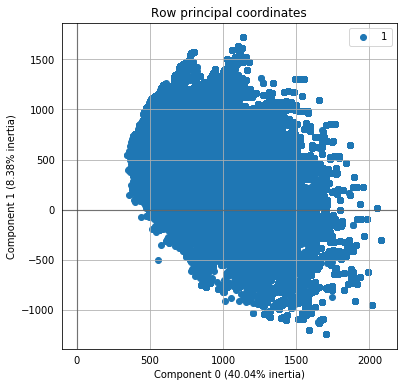

In [7]:
#famd.plot_row_coordinates(encoded_df)
famd_result.plot_row_coordinates(df_clientes[categorical_features+['edad_v2']].rename(columns={'edad_v2':'edad'}))

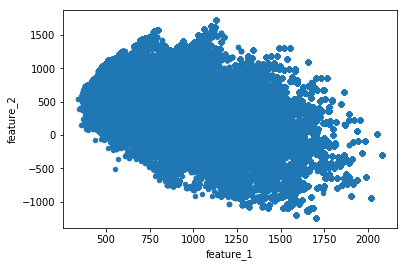

In [8]:
features_df.plot.scatter(x='feature_1',y='feature_2')

### Estandarización de datos

In [11]:
#Estandarización de los datos
scaled_data = pd.DataFrame(preprocessing.StandardScaler().fit_transform(features_df), columns =['feature_1', 'feature_2'])
#Se remueven datos iguales para de esta manera reducir el consumo de memoria necesario
#en el cálculo de la matriz de distancias usada en el algoritmo dbscan
scaled_unique_data =scaled_data.groupby(['feature_1','feature_2'],as_index=False).first()


In [58]:
#Función para la visualización de los agrupamientos
def plot_clusters(features_input, labels_input):
    import matplotlib.pyplot as plt
    
    features=features_input.reset_index(drop=True)
    labels = labels_input.reset_index(drop=True)
    
    unique_labels = np.unique(labels)
    colors = [plt.cm.Spectral(num_category) for num_category in np.linspace(0, 1, len(unique_labels))]
    
    for category,color in zip(unique_labels,colors):
        xy = features[labels==category]
        #return(xy)
        plt.plot(xy.iloc[:,0], xy.iloc[:,1],'o', markerfacecolor=tuple(color), label ='Cluster {}'.format(category))
        plt.legend(loc='upper right')
    return plt

## Agrupamiento con Dbscan

In [15]:
from sklearn.neighbors import NearestNeighbors

In [60]:
from sklearn.neighbors import radius_neighbors_graph
#Calculo de la matriz de distancias a partir de
distance_matrix = radius_neighbors_graph(scaled_unique_data, 0.05, mode='distance')

In [61]:
from sklearn.metrics import pairwise_distances_chunked

db = cluster.DBSCAN(eps=0.05, min_samples=1,algorithm='ball_tree', metric='precomputed', leaf_size=15).fit(distance_matrix) ## ->No sirve, se cuelga el pc
labels = db.labels_.copy()


In [10]:
#obtención de labels y limpieza de datos.
labels = db.labels_.copy()
del db
del distance_matrix

<module 'matplotlib.pyplot' from 'e:\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

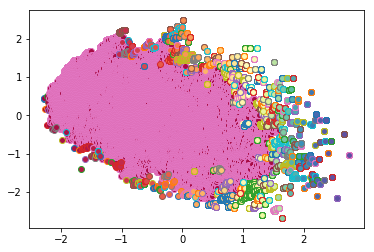

In [62]:
#Gráfico dbscan
plot_clusters(scaled_unique_data,labels)

## K-modes

In [ ]:
km = KModes(n_clusters=5, init='Huang', n_init=1)
labels_kmodes = km.fit_predict(features_df)


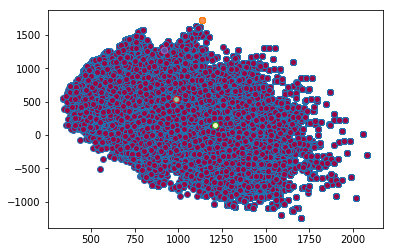

In [65]:
plt = plot_clusters(features_df,labels_kmodes)

## K-mean++

In [ ]:
#Selección del número óptimo de clusters
from sklearn.metrics import davies_bouldin_score

num_clusters = np.arange(2,8)
silhouette_score_list = []
davies_score_list = []
calinski_score_list = []
for k in num_clusters:
    #k-mean++ es el método de inicialización por defecto en la implementación de scikit-learn
    kmeans = cluster.KMeans(n_clusters =k,n_jobs=-1)
    kmeans.fit(scaled_data)

    davies_score_list.append(davies_bouldin_score(scaled_data,kmeans.labels_))


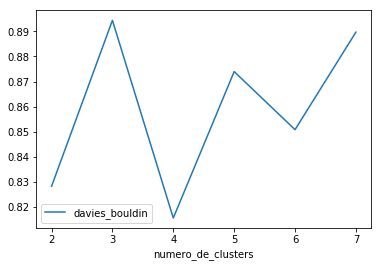

In [16]:
clusters_scores = pd.DataFrame({'numero_de_clusters':np.arange(2,8),'davies_bouldin':davies_score_list,})


clusters_scores.plot.line(x='numero_de_clusters',y='davies_bouldin')

In [17]:
#Se agregan los labels de ambos agrupadores (2 clusters y 4 clusters) al data frame para su posterior análisis.
kmeans = cluster.KMeans(n_clusters =2,n_jobs=-1)
kmeans.fit(scaled_data)
df_clientes['categoria_2_clusters'] = kmeans.labels_

kmeans = cluster.KMeans(n_clusters =4,n_jobs=-1)
kmeans.fit(scaled_data)
df_clientes['categoria_4_clusters'] = kmeans.labels_

<module 'matplotlib.pyplot' from 'e:\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

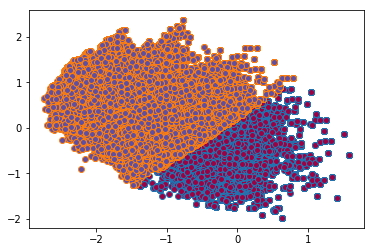

In [49]:
plot_clusters(scaled_data,df_clientes['categoria_2_clusters'])

<module 'matplotlib.pyplot' from 'e:\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

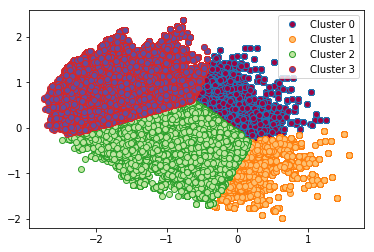

In [59]:
plot_clusters(scaled_data,df_clientes['categoria_4_clusters'])

In [38]:
#Exportación de los datos
#df_clientes.to_csv('Pagadores_v5_con_clusters.csv')

In [73]:
#Error de memoria al intentar aplicar algoritmos de la familia jerarquica
hier_aglo = cluster.Birch(n_clusters =2,linkage='average')
hier_aglo.fit(features_df)

MemoryError: 

In [53]:
df_clientes.describe(include='object')

,seg_str,ocupacion,tipo_vivienda,nivel_academico,estado_civil,genero,ingreso_rango,flag
count,324558,324558,324558,324558,324558,324558,324558,324558
unique,4,16,8,9,7,3,10,1
top,PERSONAL,1,I,U,S,F,b. (1.1 2.2MM],no
freq,226946,204783,172464,133151,171392,164959,103930,324558
